In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install the required libraries on Colab
!pip install pystan
!pip install prophet
!pip install hvplot
!pip install holoviews
!pip install jupyter_bokeh

In [ ]:
# imports
import pandas as pd
import holoviews as hv
from prophet import Prophet
import hvplot.pandas
import datetime as dt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Data Cleaning for Prophet from trip_data.csv

In [ ]:
# Create df for encoded data.
from google.colab import files
uploaded = files.upload()

# read encoded_data.csv from main data clean
encoded_data_df = pd.read_csv("encoded_data.csv",
                  index_col=0)

# preview df
display(encoded_data_df)


Saving encoded_data.csv to encoded_data (7).csv


,trip_length_miles,trip_time_seconds,base_passenger_fare_dollars,tolls_dollars,black_car_fund_dollars,sales_tax_dollars,congestion_surcharge_dollars,airport_fee_dollars,tip_dollars,driver_pay_dollars,...,pickup_borough_Bronx,pickup_borough_Brooklyn,pickup_borough_Manhattan,pickup_borough_Queens,pickup_borough_Staten Island,dropoff_borough_Bronx,dropoff_borough_Brooklyn,dropoff_borough_Manhattan,dropoff_borough_Queens,dropoff_borough_Staten Island
0,2.060,660,23.87,0.00,0.72,2.12,0.00,0.0,0.0,14.02,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.380,1379,41.66,0.00,1.25,3.70,0.00,0.0,0.0,33.24,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.390,590,34.03,0.00,1.02,3.02,2.75,0.0,0.0,45.18,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.240,461,35.71,0.00,1.07,3.17,0.00,0.0,0.0,31.67,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2.760,1029,27.69,0.00,0.83,2.46,0.00,0.0,0.0,22.54,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,4.694,1355,57.42,0.78,1.63,5.25,0.00,0.0,0.0,20.30,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11996,4.222,1304,47.12,0.00,1.18,3.82,0.00,0.0,0.0,17.96,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11997,5.470,1422,25.40,0.00,0.70,2.25,2.75,0.0,0.0,20.55,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11998,6.140,2863,34.31,0.00,0.94,3.05,2.75,0.0,0.0,39.12,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Create df for original data.
from google.colab import files
uploaded = files.upload()

# read trip_data.csv from original data
trip_data_df = pd.read_csv("trip_data.csv",
                infer_datetime_format=True,
                parse_dates=True)

# preview df
display(trip_data_df)

Saving trip_data.csv to trip_data (10).csv


,request_datetime,hvfhs_license_num,dispatching_base_num,originating_base_num,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,2023-01-01 01:23:54,HV0003,B03404,B03404,2023-01-01 01:32:20,2023-01-01 01:34:04,2023-01-01 01:45:04,235,18,2.060,...,2.12,0.00,0.0,0.0,14.02,N,N,,N,N
1,2023-01-01 01:58:19,HV0003,B03404,B03404,2023-01-01 02:02:31,2023-01-01 02:02:53,2023-01-01 02:25:52,37,33,4.380,...,3.70,0.00,0.0,0.0,33.24,N,N,,N,N
2,2023-01-01 01:59:09,HV0003,B03404,B03404,2023-01-01 02:02:30,2023-01-01 02:04:02,2023-01-01 02:13:52,232,148,1.390,...,3.02,2.75,0.0,0.0,45.18,N,N,,N,N
3,2023-01-01 02:14:02,HV0003,B03404,B03404,2023-01-01 02:22:59,2023-01-01 02:23:19,2023-01-01 02:31:00,255,256,1.240,...,3.17,0.00,0.0,0.0,31.67,N,N,,N,N
4,2023-01-01 02:16:53,HV0003,B03404,B03404,2023-01-01 02:23:39,2023-01-01 02:24:02,2023-01-01 02:41:11,223,129,2.760,...,2.46,0.00,0.0,0.0,22.54,N,N,,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2023-12-31 22:08:52,HV0005,B03406,NaN,NaN,2023-12-31 22:20:42,2023-12-31 22:43:17,60,244,4.694,...,5.25,0.00,0.0,0.0,20.30,N,N,N,N,N
11996,2023-12-31 22:17:11,HV0005,B03406,NaN,NaN,2023-12-31 22:23:08,2023-12-31 22:44:52,188,165,4.222,...,3.82,0.00,0.0,0.0,17.96,N,N,N,N,N
11997,2023-12-31 22:30:20,HV0003,B03404,B03404,2023-12-31 22:34:13,2023-12-31 22:36:14,2023-12-31 22:59:56,225,148,5.470,...,2.25,2.75,0.0,0.0,20.55,N,N,N,N,N
11998,2023-12-31 22:31:17,HV0003,B03404,B03404,2023-12-31 22:33:22,2023-12-31 22:35:24,2023-12-31 23:23:07,65,50,6.140,...,3.05,2.75,0.0,0.0,39.12,N,N,N,N,Y


In [ ]:
# Create combined df of y-hat ("good_fare") and datetime of request
df = pd.concat([trip_data_df["request_datetime"], encoded_data_df["good_fare"]], axis=1)

# eliminate duplicated datetimes
df = df.groupby("request_datetime").mean()

# reset axis
df.reset_index(inplace=True)

# Label the columns ds and y so that the syntax is recognized by Prophet
df.columns=["ds", "y"]

# Drop an NaN values from the prophet_df DataFrame
df.dropna(inplace=True)

# Preview
df.head()

,ds,y
0,2023-01-01 01:23:54,0.0
1,2023-01-01 01:58:19,0.0
2,2023-01-01 01:59:09,0.0
3,2023-01-01 02:14:02,0.0
4,2023-01-01 02:16:53,0.0


In [ ]:
df.value_counts(subset="y")

y  
0.0    11478
1.0      520
dtype: int64

Prophet Code

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpokh5jsqp/40oky4lm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpokh5jsqp/_bdsrqto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93920', 'data', 'file=/tmp/tmpokh5jsqp/40oky4lm.json', 'init=/tmp/tmpokh5jsqp/_bdsrqto.json', 'output', 'file=/tmp/tmpokh5jsqp/prophet_modelcheltfyx/prophet_model-20240313044229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


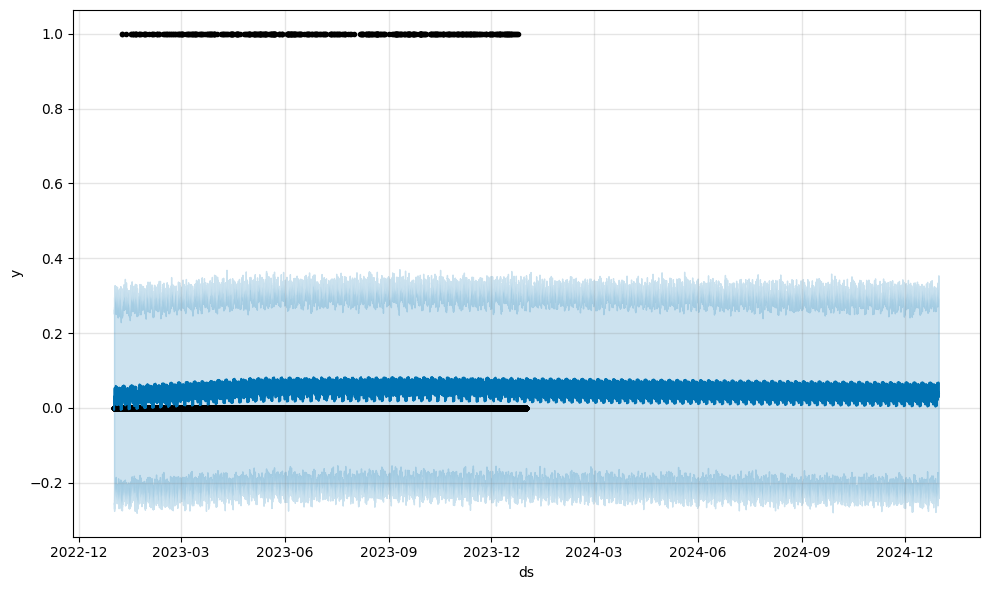

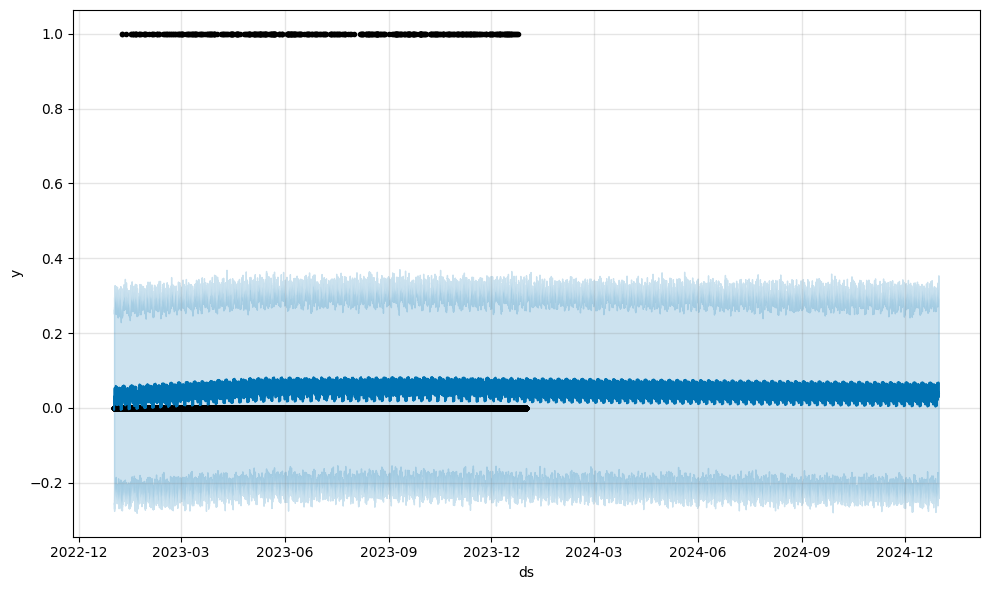

In [ ]:
# Call the Prophet function, store as an object
model = Prophet()

# Fit the time-series model.
model.fit(df)

# Create a future dataframe to hold predictions
future_good_fare_trends = model.make_future_dataframe(periods=8760, freq="H")

# Make the predictions for the trend data using the future_mercado_trends DataFrame
# this creates values for the dates that have been created in the model
forecast_good_fare_trends = model.predict(future_good_fare_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast_good_fare_trends.head()

# Plot the Prophet predictions for the Mercado trends data
# this plots the forecast
prophet_plot = model.plot(forecast_good_fare_trends)

prophet_plot.savefig("prophet_365.png")

prophet_plot

Timeseries components.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
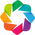

:NdOverlay   [Variable]
   :Curve   [ds]   (value)

In [ ]:
forecast_good_fare_trends.columns

# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
# it automatically did this, so I didn't have to run this code
forecast_good_fare_trends.set_index("ds", inplace=True)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_good_fare_trends[["yhat", "yhat_lower", "yhat_upper"]]

# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# From the forecast_mercado_trends DataFrame, use hvPlot to visualize
forecast_good_fare_trends[["yhat", "yhat_lower", "yhat_upper"]].iloc[-8760:,:].hvplot(
    frame_width=800,
    x="ds",
    title="yhat Projections"
)


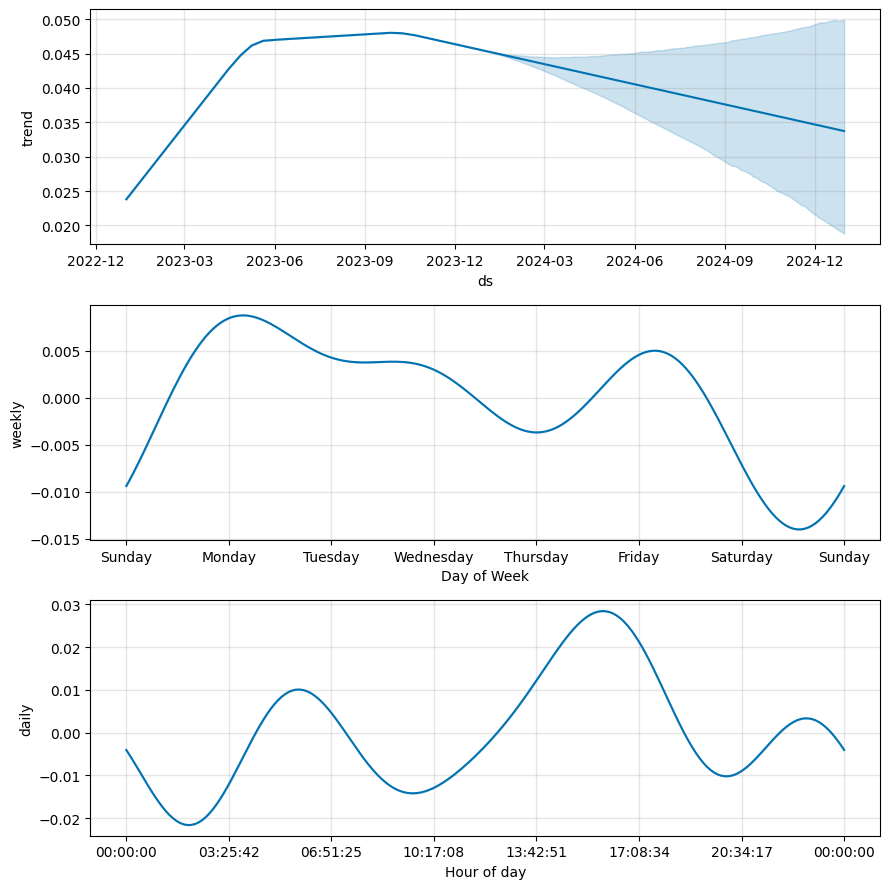

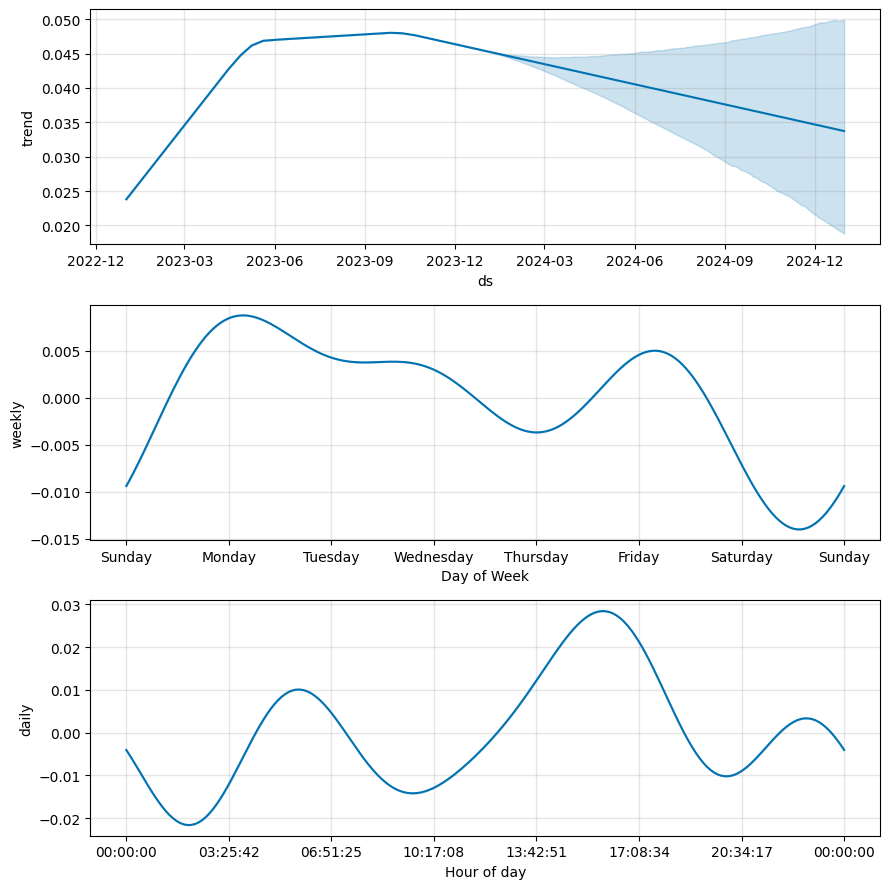

In [ ]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_good_fare_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
components_plot = model.plot_components(forecast_good_fare_trends)

components_plot.savefig("prophet_components.png")

components_plot